In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from IPython.display import HTML

from os import listdir
print(listdir("../input"))

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# Any results you write to the current directory are saved as output.

['test', 'sample_submission.csv', 'train.csv']


In [3]:
train = pd.read_csv("../input/train.csv", nrows=10000000,
                    dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
train.head(5)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [4]:
train.rename({"acoustic_data": "signal", "time_to_failure": "quaketime"}, axis="columns", inplace=True)
train.head(5)

,signal,quaketime
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [5]:
for n in range(5):
    print(train.quaketime.values[n])

1.4690999832
1.4690999821000001
1.4690999809999998
1.4690999799000002
1.4690999787999999


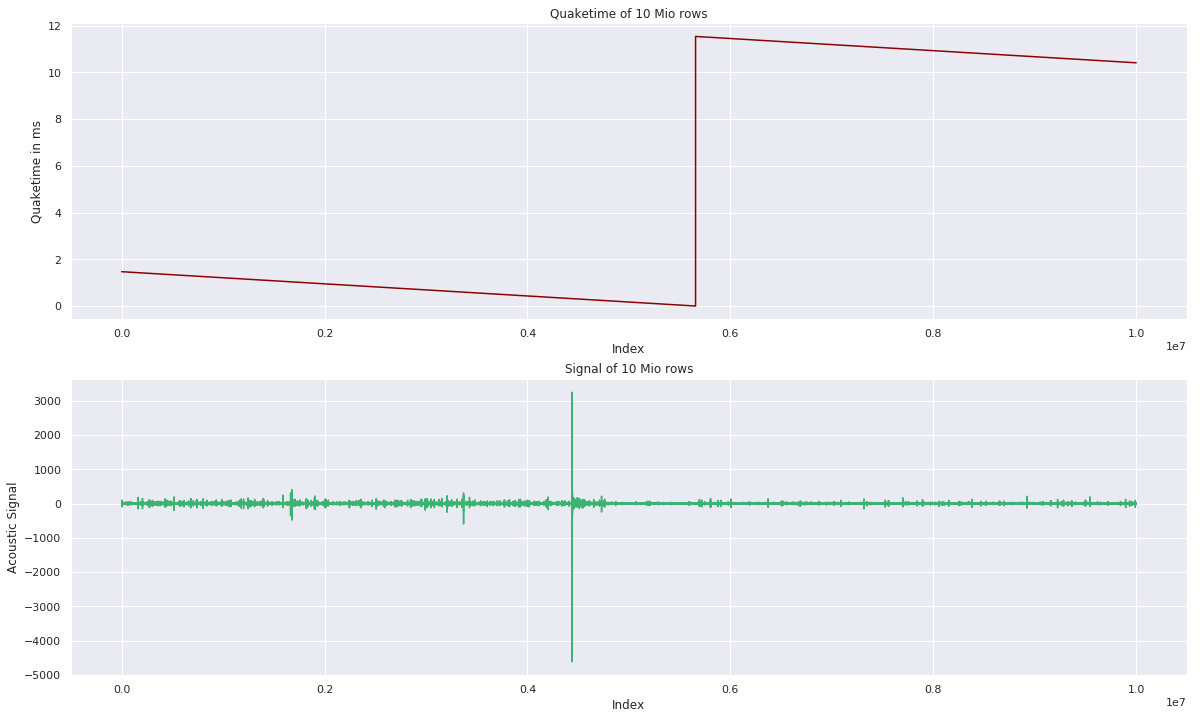

In [6]:
fig, ax = plt.subplots(2,1, figsize=(20,12))
ax[0].plot(train.index.values, train.quaketime.values, c="darkred")
ax[0].set_title("Quaketime of 10 Mio rows")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Quaketime in ms");
ax[1].plot(train.index.values, train.signal.values, c="mediumseagreen")
ax[1].set_title("Signal of 10 Mio rows")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Acoustic Signal");

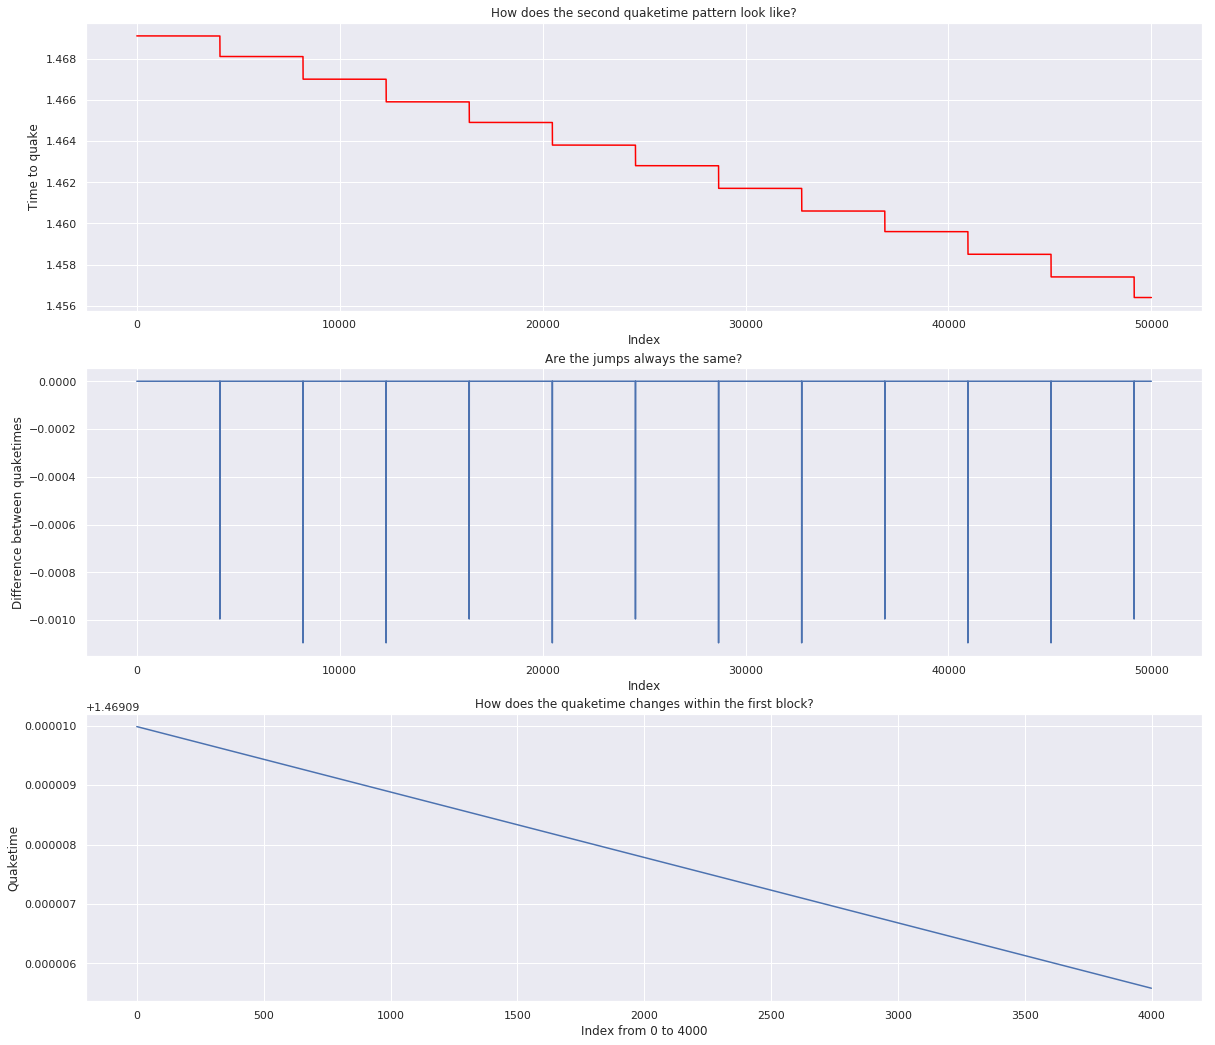

In [7]:
fig, ax = plt.subplots(3,1,figsize=(20,18))
ax[0].plot(train.index.values[0:50000], train.quaketime.values[0:50000], c="Red")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Time to quake")
ax[0].set_title("How does the second quaketime pattern look like?")
ax[1].plot(train.index.values[0:49999], np.diff(train.quaketime.values[0:50000]))
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Difference between quaketimes")
ax[1].set_title("Are the jumps always the same?")
ax[2].plot(train.index.values[0:4000], train.quaketime.values[0:4000])
ax[2].set_xlabel("Index from 0 to 4000")
ax[2].set_ylabel("Quaketime")
ax[2].set_title("How does the quaketime changes within the first block?");

In [8]:
test_path = "../input/test/"

In [9]:
test_files = listdir("../input/test")
print(test_files[0:5])

['seg_d5df41.csv', 'seg_abda04.csv', 'seg_421a96.csv', 'seg_d31583.csv', 'seg_14c054.csv']


In [10]:
len(test_files)

2624

In [11]:
sample_submission = pd.read_csv("../input/sample_submission.csv")
sample_submission.head(2)

,seg_id,time_to_failure
0,seg_00030f,0
1,seg_0012b5,0


In [12]:
len(sample_submission.seg_id.values)

2624

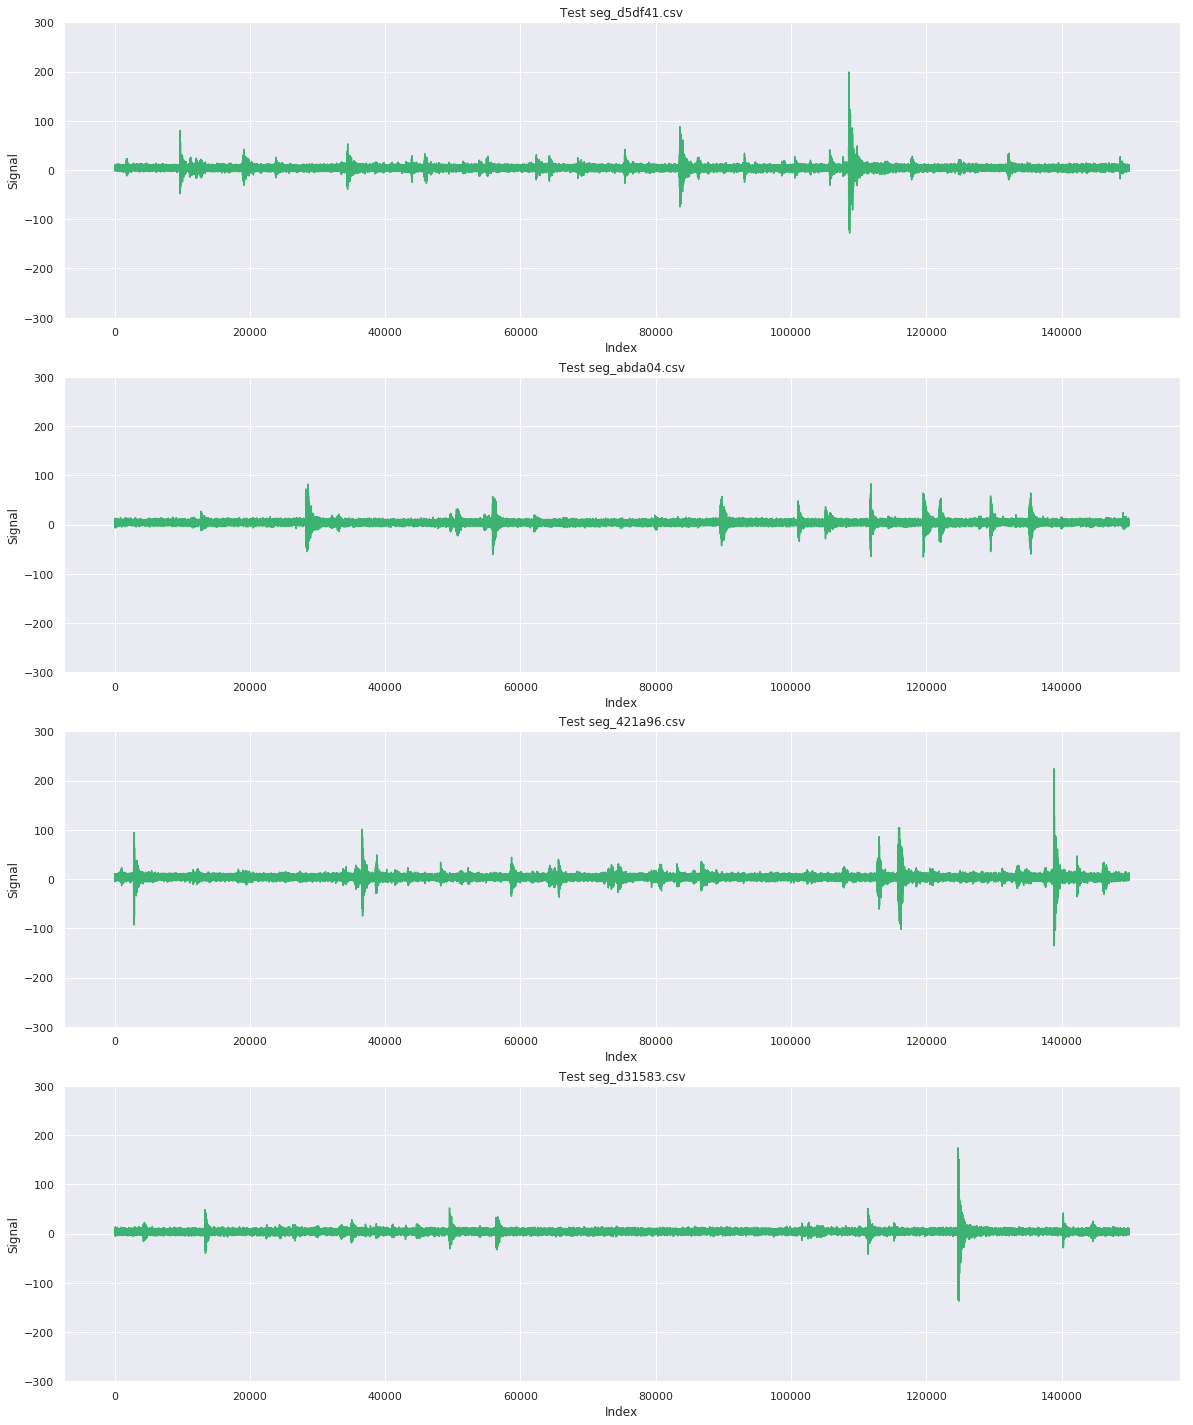

In [13]:
fig, ax = plt.subplots(4,1, figsize=(20,25))

for n in range(4):
    seg = pd.read_csv(test_path  + test_files[n])
    ax[n].plot(seg.acoustic_data.values, c="mediumseagreen")
    ax[n].set_xlabel("Index")
    ax[n].set_ylabel("Signal")
    ax[n].set_ylim([-300, 300])
    ax[n].set_title("Test {}".format(test_files[n]));

In [14]:
train.describe()

,signal,quaketime
count,1.000000e+07,1.000000e+07
mean,4.502072e+00,5.183598e+00
std,1.780707e+01,5.091286e+00
min,-4.621000e+03,7.954798e-04
25%,2.000000e+00,6.498971e-01
50%,4.000000e+00,1.298899e+00
75%,7.000000e+00,1.089170e+01
max,3.252000e+03,1.154080e+01


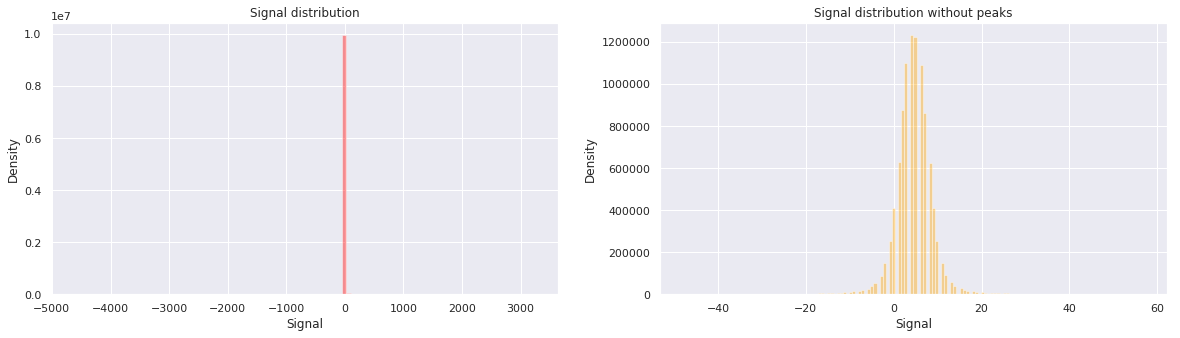

In [15]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(train.signal.values, ax=ax[0], color="Red", bins=100, kde=False)
ax[0].set_xlabel("Signal")
ax[0].set_ylabel("Density")
ax[0].set_title("Signal distribution")

low = train.signal.mean() - 3 * train.signal.std()
high = train.signal.mean() + 3 * train.signal.std() 
sns.distplot(train.loc[(train.signal >= low) & (train.signal <= high), "signal"].values,
             ax=ax[1],
             color="Orange",
             bins=150, kde=False)
ax[1].set_xlabel("Signal")
ax[1].set_ylabel("Density")
ax[1].set_title("Signal distribution without peaks");

In [16]:
stepsize = np.diff(train.quaketime)
train = train.drop(train.index[len(train)-1])
train["stepsize"] = stepsize
train.head(5)

,signal,quaketime,stepsize
0,12,1.4691,-1.100000e-09
1,6,1.4691,-1.100000e-09
2,8,1.4691,-1.100000e-09
3,5,1.4691,-1.100000e-09
4,8,1.4691,-1.100000e-09


In [17]:
train.stepsize = train.stepsize.apply(lambda l: np.round(l, 10))

In [18]:
stepsize_counts = train.stepsize.value_counts()
stepsize_counts

-1.100000e-09    5655193
-1.000000e-09    3907598
-2.000000e-09     434767
-1.095496e-03        882
-1.095495e-03        679
-9.954955e-04        497
-9.954950e-04        381
-1.095497e-03          1
 1.154000e+01          1
Name: stepsize, dtype: int64

In [19]:
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=5)

In [20]:
window_sizes = [10, 50, 100, 1000]
for window in window_sizes:
    train["rolling_mean_" + str(window)] = train.signal.rolling(window=window).mean()
    train["rolling_std_" + str(window)] = train.signal.rolling(window=window).std()

In [21]:
train["rolling_q25"] = train.signal.rolling(window=50).quantile(0.25)
train["rolling_q75"] = train.signal.rolling(window=50).quantile(0.75)
train["rolling_q50"] = train.signal.rolling(window=50).quantile(0.5)
train["rolling_iqr"] = train.rolling_q75 - train.rolling_q25
train["rolling_min"] = train.signal.rolling(window=50).min()
train["rolling_max"] = train.signal.rolling(window=50).max()
train["rolling_skew"] = train.signal.rolling(window=50).skew()
train["rolling_kurt"] = train.signal.rolling(window=50).kurt()